In [1]:
import os
os.environ["PATH"] = "/usr/local/cuda-11.8/bin:{}".format(os.environ["PATH"])
os.environ["LD_LIBRARY_PATH"] = "/usr/local/cuda-11.8/lib64"

import sys
sys.path.append("/data1/yang_liu/python_workspace/GSPL")
os.environ['CUDA_VISIBLE_DEVICES'] = '7'

import random
import torch
import numpy as np
from matplotlib import pyplot as plt
from gsplat.rasterize import rasterize_gaussians
from internal.utils.gaussian_model_loader import GaussianModelLoader
from internal.dataparsers.colmap_dataparser import Colmap, ColmapDataParser

torch.set_grad_enabled(False)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
device = torch.device("cuda")
# input parameters
ckpt_path = "../outputs/CO3D_vggt_opt_pcd50_vggt_opt_mcmc_x_gamma_epi_test/apple_vggt_opt_mcmc_x_gamma_epi"
ref_folder_path = "../data/CO3D"

# loading model and renderer
assert 'test' in ckpt_path, "Please provide a test checkpoint path."

load_from = GaussianModelLoader.search_load_file(ckpt_path)
ckpt = torch.load(load_from, map_location="cpu")
scene = ckpt["datamodule_hyper_parameters"]["path"].split("/")[-1]
ref_dataset_path = os.path.join(ref_folder_path, scene)
dataset_path = os.path.join("../", ckpt["datamodule_hyper_parameters"]["path"])

bkgd_color = ckpt["hyper_parameters"]["background_color"]
model = GaussianModelLoader.initialize_model_from_checkpoint(
    ckpt,
    device=device,
)
model.freeze()
model.pre_activate_all_properties()

# initialize renderer
renderer = GaussianModelLoader.initialize_renderer_from_checkpoint(
    ckpt,
    stage="validate",
    device=device,
)
print("Gaussian count: {}".format(model.get_xyz.shape[0]))

Gaussian count: 500000


In [3]:
dataparser_config = ckpt["datamodule_hyper_parameters"]["parser"]

dataparser_outputs = dataparser_config.instantiate(
    path=dataset_path,
    output_path=os.getcwd(),
    global_rank=0,
).get_outputs()

ref_dataparser_outputs = dataparser_config.instantiate(
    path=ref_dataset_path,
    output_path=os.getcwd(),
    global_rank=0,
).get_outputs()

appearance group by camera id
loading colmap 3D points
[colmap dataparser] train set images: 26, val set images: 176, loaded mask: 0
appearance group by camera id
loading colmap 3D points
[colmap dataparser] train set images: 26, val set images: 176, loaded mask: 0


In [8]:
from tools.metric_torch import evaluate_auc, umeyama

# correct test view poses
w2cs_train_pred = torch.transpose(dataparser_outputs.train_set.cameras.world_to_camera, -2, -1).to(device)
w2cs_val_pred = torch.transpose(dataparser_outputs.val_set.cameras.world_to_camera, -2, -1).to(device)
w2cs_pred = torch.concatenate([w2cs_train_pred, w2cs_val_pred], dim=0)
appearance_ids_pred = torch.concatenate([dataparser_outputs.train_set.cameras.appearance_id, 
                                         dataparser_outputs.val_set.cameras.appearance_id], dim=0).to(device)
c2ws_pred = torch.linalg.inv(w2cs_pred)
c2ws_pred_corrected = renderer.model(c2ws_pred, appearance_ids_pred)
w2cs_pred_corrected = torch.linalg.inv(c2ws_pred_corrected)

pred_se3 = torch.eye(4, device=device).unsqueeze(0).repeat(len(w2cs_pred), 1, 1)
pred_se3[:, :3, :3] = torch.tensor(w2cs_pred[:, :3, :3], device=device)
pred_se3[:, 3, :3] = torch.tensor(w2cs_pred[:, :3, 3], device=device)

pred_se3_corrected = torch.eye(4, device=device).unsqueeze(0).repeat(len(w2cs_pred_corrected), 1, 1)
pred_se3_corrected[:, :3, :3] = torch.tensor(w2cs_pred_corrected[:, :3, :3], device=device)
pred_se3_corrected[:, 3, :3] = torch.tensor(w2cs_pred_corrected[:, :3, 3], device=device)

w2cs_train_ref = torch.transpose(ref_dataparser_outputs.train_set.cameras.world_to_camera, -2, -1).to(device)
w2cs_val_ref = torch.transpose(ref_dataparser_outputs.val_set.cameras.world_to_camera, -2, -1).to(device)
w2cs_ref = torch.concatenate([w2cs_train_ref, w2cs_val_ref], dim=0)

gt_se3 = torch.eye(4, device=device).unsqueeze(0).repeat(len(w2cs_ref), 1, 1)
gt_se3[:, :3, :3] = torch.tensor(w2cs_ref[:, :3, :3], device=device)
gt_se3[:, 3, :3] = torch.tensor(w2cs_ref[:, :3, 3], device=device)

auc_results = evaluate_auc(pred_se3_corrected, gt_se3, device)

    --  Umeyama Scale:  2.1534987170835507
    --  Umeyama Rotation: 
 [[ 0.99835933 -0.04942432 -0.02891143]
 [ 0.03249182  0.90475528 -0.42469068]
 [ 0.0471478   0.42305453  0.90487673]]
    --  Umeyama Translation: 
 [[0.16479062]
 [1.458734  ]
 [0.38878242]]
    --  Pair Rot   Error (Deg) of Vanilla:       1.62
    --  Pair Trans Error (Deg) of Vanilla:       4.80
    --  AUC at 30: 0.8517


/tmp/ipykernel_53435/545673495.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred_se3[:, :3, :3] = torch.tensor(w2cs_pred[:, :3, :3], device=device)
/tmp/ipykernel_53435/545673495.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred_se3[:, 3, :3] = torch.tensor(w2cs_pred[:, :3, 3], device=device)
/tmp/ipykernel_53435/545673495.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred_se3_corrected[:, :3, :3] = torch.tensor(w2cs_pred_corrected[:, :3, :3], device=device)
/tmp/ipykernel_53435/545673495.py:19: UserWarning: To copy

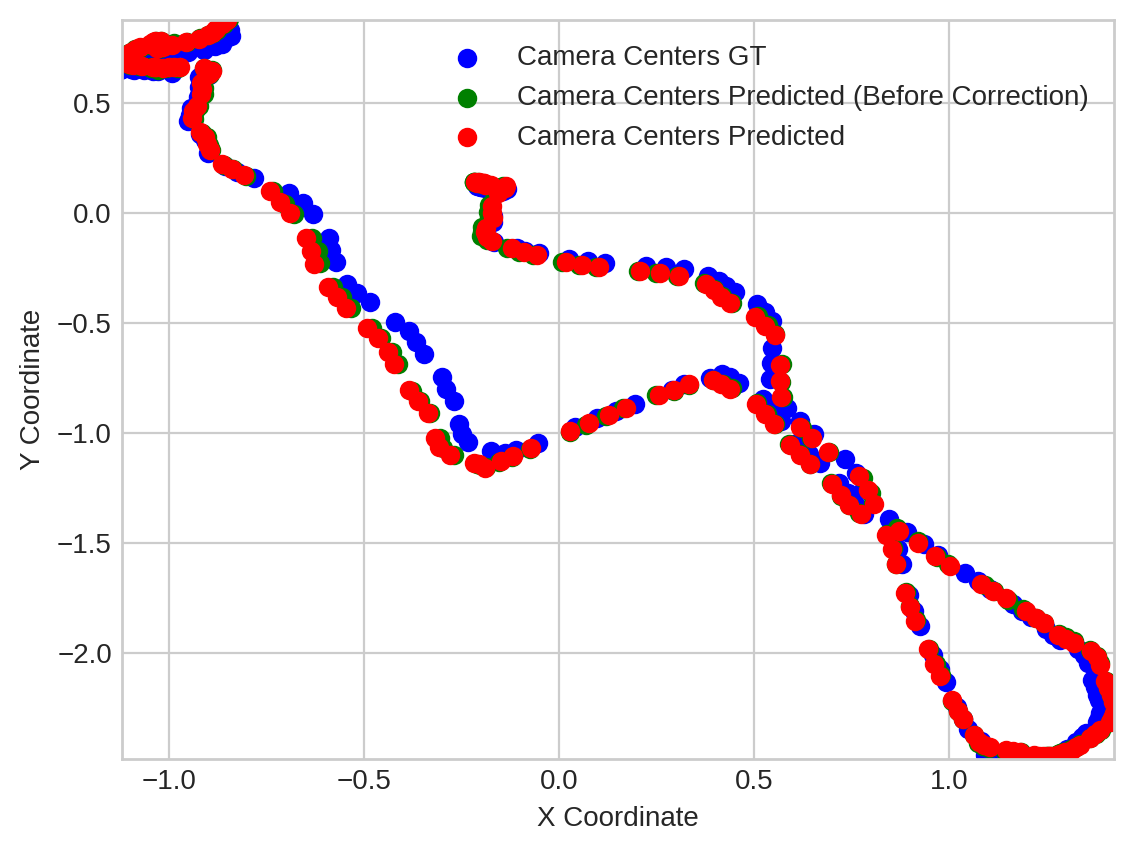

In [11]:
camera_centers_gt = - (gt_se3[:, :3, :3].cpu().numpy().transpose(0, 2, 1) @ gt_se3[:, 3, :3][..., None].cpu().numpy()).squeeze(-1)
camera_centers_pred = - (pred_se3[:, :3, :3].cpu().numpy().transpose(0, 2, 1) @ pred_se3[:, 3, :3][..., None].cpu().numpy()).squeeze(-1)
camera_centers_pred_corrected = - (pred_se3_corrected[:, :3, :3].cpu().numpy().transpose(0, 2, 1) @ pred_se3_corrected[:, 3, :3][..., None].cpu().numpy()).squeeze(-1)
c, R, t = umeyama(camera_centers_gt.T, camera_centers_pred_corrected.T)
camera_centers_gt_aligned = (c * (R @ camera_centers_gt.T) + t).T
variance = np.var(camera_centers_pred_corrected, axis=0)
ground_plane_indices = np.argsort(variance)[1:]
pcd_interval = 10

plt.style.use("seaborn-v0_8-whitegrid")
plt.figure()
plt.scatter(camera_centers_gt_aligned[:, ground_plane_indices[0]], camera_centers_gt_aligned[:, ground_plane_indices[1]], c='blue', label='Camera Centers GT')
plt.scatter(camera_centers_pred[:, ground_plane_indices[0]], camera_centers_pred[:, ground_plane_indices[1]], c='green', label='Camera Centers Predicted (Before Correction)')
plt.scatter(camera_centers_pred_corrected[:, ground_plane_indices[0]], camera_centers_pred_corrected[:, ground_plane_indices[1]], c='red', label='Camera Centers Predicted')
plt.xlim(camera_centers_pred_corrected[:, ground_plane_indices[0]].min(), camera_centers_pred_corrected[:, ground_plane_indices[0]].max())
plt.ylim(camera_centers_pred_corrected[:, ground_plane_indices[1]].min(), camera_centers_pred_corrected[:, ground_plane_indices[1]].max())
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.legend()